<h1> Dynamic Topic Modelling Using MNF (see Greene) </h1>

In [1]:
#!python -m pip install -U prettytable

In [2]:
import pandas as pd
import numpy
import pickle
import time
import joblib
import gensim
import matplotlib.pyplot as plt
import unsupervised.nmf, unsupervised.rankings


from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel

In [3]:
# Modify the pre-processing function
def preprocess(df, stopwords):
    # Append all the final tokens
    text = []
    docs = df['final_tokens']
    
    for abstract in docs:
        text.append(' '.join(abstract))
        
    # Create the term-document matrix
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=0, lowercase=False, stop_words=stop_wds)
    tf_idf = tfidf_vectorizer.fit_transform(text)
    
    # store the vocabulary map
    v = tfidf_vectorizer.vocabulary_
    terms = []
    for i in range(len(v)):
        terms.append("")
    for term in v.keys():
        terms[ v[term] ] = term
        
    return (tf_idf,terms)

In [4]:
# Load the dataset. Apply the DTM on the coronavirus corpus (1000 abstracts)
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/case_studies/coronavirus_corpus.pkl', 'rb')
df = pickle.load(f)
f.close()
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,...,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
5122,5122,5608,95622,Host - virus interactions are greatly affected...,2008,Affect; Antiviral Agents; Area; Biochemical; D...,THE ROLE OF A HOST ION PUMP IN RNA VIRUS RECOM...,NSF,NSF,NaN,...,UNITED STATES,NaN,NaN,47.074,2008,612000.0,NaN,1,1,"[host, virus, interaction, greatly, affect, ex..."
13938,13938,15726,152221,AbstractThe American Society for Virology (ASV...,2008,abstracting; Acquired Immunodeficiency Syndrom...,"INTERNATIONAL CONGRESS OF VIROLOGY, ISTANBUL, ...",HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2009,93.855,2008,30000.0,NaN,1,1,"[american, society, virology_asv, wish, provid..."
14418,14418,17118,153617,DESCRIPTION (provided by applicant): Severe a...,2008,Abbreviations; Address; Alleles; Alphavirus; A...,SARS REVERSE GENETICS,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,271608.0,NaN,1,1,"[severe, acute, respiratory, syndrome, life_th..."
14514,14514,17384,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,75292.0,NaN,1,1,"[human, coronaviruse_hcov, initially, identify..."
14565,14565,17526,154033,"DESCRIPTION: Plus-stranded RNA viruses, which ...",2008,Affect; Agriculture; Animals; Antiviral Agents...,ROLES OF HOST RNA BINDING PROTEINS IN VIRUS RE...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,200124.0,NaN,1,1,"[strand, rna, virus, pose, significant, risk, ..."


<h2> Pre-processing </h2>

In [5]:
# Transform dataset as in Greene. Create a data sample for each year
year_list = df['FY'].unique()

for year in year_list:
    df_subset = df[df['FY']==year]
    
    # save the pickle file
    pickle.dump(df_subset, open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/data/Coronavirus_'+str(year)+'.pkl','wb'))

In [6]:
# Create the term-document matrix tfidf for each pkl file
stop_wds = ['research', 'study', 'project']  # use will be eliminated by max_df

for year in year_list:
    # Load the sample for a given year
    f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/data/Coronavirus_'+str(year)+'.pkl', 'rb')
    df = pickle.load(f)
    f.close()
            
    # Pre-processing the pkl file
    (tf_idf,terms) = preprocess(df, stop_wds)
    
    # Save the term-document matrix
    joblib.dump((tf_idf,terms,df), '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/Term_docs_'+str(year)+'.pkl' )

<h2> Window Topic Modeling </h2>

In [7]:
# Create a windows-topics by applying NMF on each tfidf pkl file
# Number of topic per windows k= 30
!python find-window-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/*.pkl -k 30,30 -o /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out

Using random seed 1000
- Processing time window matrix for 'Term_docs_2008' from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/Term_docs_2008.pkl ...
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Read 103x3818 document-term matrix
Generating models in range [30,30] ...
Applying window topic modeling to matrix for k=30 topics ...
/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
Generated 103x30 factor W and 30x3818 factor H
Writing results to /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Saving NMF results to /project/biocomplexity/sdad/projects_data/ncses/prd/D

In [8]:
# Display topics 
# Example with windows=2008
!python display-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl 

Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
- Loaded model with 30 topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Top 10 terms for 30 topics:
+------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| Rank | Term_docs_2008_01 | Term_docs_2008_02 | Term_docs_2008_03 | Term_docs_2008_04 | Term_docs_2008_05 | Term_docs_2008_06 | Term_docs_2008_07 | Term_docs_2008_08 |
+------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|    1 | host              | influenza         | sars_cov          | inhibitor         | vaccine           | ebola             | 1918              | ace2              |
|    2 | r

<h2> Dynamic Topic Modeling </h2>

In [9]:
# Solve for NMF-DTM
# number of topics for the 2nd step k=30 
!python find-dynamic-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2013_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2014_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2015_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2016_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2017_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2018_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2019_windowtopics_k30.pkl -k 30,30 -o /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out

Using random seed 1000
- Processing individual time window topic models ...
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k30.pkl
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k30.pkl
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k30.pkl
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k30.pkl
Loaded 30 time wind

In [10]:
# Display the topic list from the NMF-DTM
!python display-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k30.pkl

- Loaded model with 30 topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k30.pkl
Top 10 terms for 30 topics:
+------+-------------+-----------+-------------+-------------+----------------+-------------+-------------+------------+
| Rank | D01         | D02       | D03         | D04         | D05            | D06         | D07         | D08        |
+------+-------------+-----------+-------------+-------------+----------------+-------------+-------------+------------+
|    1 | rna         | influenza | mouse       | disease     | fusion         | fidelity    | core        | ace2       |
|    2 | replication | virus     | aged        | lung        | peptide        | compound    | stock       | sar_cov    |
|    3 | host        | pandemic  | response    | patient     | protein        | cov         | virus       | epithelial |
|    4 | viral       | 1918      | cell        | infectious  | membrane       | vivo        | recombinan

In [11]:
# Track the dynamic
# Displays the dynamic of topic 3 (specify the -d 3 at the end of the line)
!python track-dynamic-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2013_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2014_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2015_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2016_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2017_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2018_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2019_windowtopics_k30.pkl -d 12

Loaded model with 30 dynamic topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k30.pkl
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Loaded model with 30 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Loaded model with 30 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k30.pkl
Loaded model with 30 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k30.pkl
Loaded model with 30 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k30.pkl
Loaded model with 30 window topics from /project/biocomplexity/sdad/projects_d

<h2> 3. Compute the topic coherence </h2>

In [12]:
# Build the dictionary and corpus
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/case_studies/coronavirus_corpus.pkl', 'rb')
df = pickle.load(f)
f.close()
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,...,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
5122,5122,5608,95622,Host - virus interactions are greatly affected...,2008,Affect; Antiviral Agents; Area; Biochemical; D...,THE ROLE OF A HOST ION PUMP IN RNA VIRUS RECOM...,NSF,NSF,NaN,...,UNITED STATES,NaN,NaN,47.074,2008,612000.0,NaN,1,1,"[host, virus, interaction, greatly, affect, ex..."
13938,13938,15726,152221,AbstractThe American Society for Virology (ASV...,2008,abstracting; Acquired Immunodeficiency Syndrom...,"INTERNATIONAL CONGRESS OF VIROLOGY, ISTANBUL, ...",HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2009,93.855,2008,30000.0,NaN,1,1,"[american, society, virology_asv, wish, provid..."
14418,14418,17118,153617,DESCRIPTION (provided by applicant): Severe a...,2008,Abbreviations; Address; Alleles; Alphavirus; A...,SARS REVERSE GENETICS,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,271608.0,NaN,1,1,"[severe, acute, respiratory, syndrome, life_th..."
14514,14514,17384,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,75292.0,NaN,1,1,"[human, coronaviruse_hcov, initially, identify..."
14565,14565,17526,154033,"DESCRIPTION: Plus-stranded RNA viruses, which ...",2008,Affect; Agriculture; Animals; Antiviral Agents...,ROLES OF HOST RNA BINDING PROTEINS IN VIRUS RE...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,200124.0,NaN,1,1,"[strand, rna, virus, pose, significant, risk, ..."


In [13]:
# Function to compute the corpus and dictionary for the DTM LDA
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['project']])

    # Create Corpus (Term Document Frequency)

    #Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
    # corpus not need for c_v coherence
    corpus = [id2word.doc2bow(doc) for doc in docs]

    return id2word, corpus

In [14]:
# build the dictionary id2word
docs = df["final_tokens"]
[dictionary, corpus] = createLDAvars(docs)

In [15]:
# Import result
dynamic_res = unsupervised.nmf.load_nmf_results('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k30.pkl')
dynamic_k = len(dynamic_res[2])

In [16]:
# Build the topic-words and limits on the top 10 words
dynamic_term_rankings = unsupervised.rankings.truncate_term_rankings( dynamic_res[2], 10 )

# Build the dictionary
cm = CoherenceModel(topics=dynamic_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', processes=30)
coherence = cm.get_coherence()  # get coherence value
print ("The coherence from the second step is ", coherence)

The coherence from the second step is  0.5953808964904006


/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k30.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k30.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k30.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k30.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2013_windowtopics_k30.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2014_windowtopics_k30.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2015_windowtopics_k30.pkl
/project/biocomplexity/sdad/proj

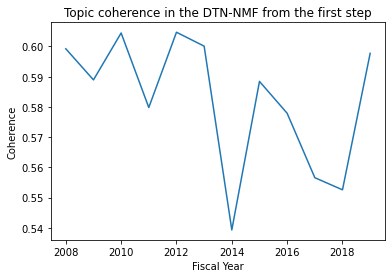

In [17]:
# The coherence pattern at the first step
# Comments: All topics from the first step has been cluster into k groups
# change observed within a cluster over time represents the topic evolution
df['Year'] = df['FY']
time_slice = df['PROJECT_ID'].groupby(df['Year']).count()
time = list(time_slice.index)
time_coherence = []

for t in time:
    d = int(t)
    print('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_%d_windowtopics_k30.pkl' %d)
    window_res = unsupervised.nmf.load_nmf_results('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_%d_windowtopics_k30.pkl' %d )
    window_k = len(window_res[2])
    window_term_rankings = unsupervised.rankings.truncate_term_rankings( window_res[2], 10 )
    
    # compute the coherence
    cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', processes=30)
    time_coherence.append(cm.get_coherence())
    
coherence_tm = pd.Series(time_coherence, index =time)
print ("The average coherence is ", coherence_tm.mean())

serie = coherence_tm.plot()
plt.title('Topic coherence in the DTN-NMF from the first step')
plt.xlabel("Fiscal Year")
plt.ylabel("Coherence")
plt.savefig('coherence_NMF_first.png')

In [27]:
# Comment: All topic from the first step have 
#          This have an implication when computing the coherence
# Create a map of window topic label -> dynamic topic
assigned_window_map = {}
dynamic_partition = dynamic_res[3]
for idx, window_topic_label in enumerate(dynamic_res[0]):
    assigned_window_map[window_topic_label] = dynamic_partition[idx]
    
# Print the association
assigned_window_map

## There is an issue. Lets take the k=30 topics in the first step at time=2008, There is multiple topics that have been assign to the same cluster (topic 10,11 -> 11 and topic 12,13 - >18)
# It suggests that k=30 is higher for the first step, 

{'Term_docs_2008_01': 0,
 'Term_docs_2008_02': 1,
 'Term_docs_2008_03': 2,
 'Term_docs_2008_04': 24,
 'Term_docs_2008_05': 12,
 'Term_docs_2008_06': 24,
 'Term_docs_2008_07': 1,
 'Term_docs_2008_08': 7,
 'Term_docs_2008_09': 21,
 'Term_docs_2008_10': 11,
 'Term_docs_2008_11': 11,
 'Term_docs_2008_12': 18,
 'Term_docs_2008_13': 18,
 'Term_docs_2008_14': 15,
 'Term_docs_2008_15': 28,
 'Term_docs_2008_16': 23,
 'Term_docs_2008_17': 1,
 'Term_docs_2008_18': 3,
 'Term_docs_2008_19': 15,
 'Term_docs_2008_20': 23,
 'Term_docs_2008_21': 10,
 'Term_docs_2008_22': 4,
 'Term_docs_2008_23': 26,
 'Term_docs_2008_24': 29,
 'Term_docs_2008_25': 24,
 'Term_docs_2008_26': 20,
 'Term_docs_2008_27': 29,
 'Term_docs_2008_28': 3,
 'Term_docs_2008_29': 15,
 'Term_docs_2008_30': 16,
 'Term_docs_2009_01': 29,
 'Term_docs_2009_02': 12,
 'Term_docs_2009_03': 24,
 'Term_docs_2009_04': 16,
 'Term_docs_2009_05': 29,
 'Term_docs_2009_06': 1,
 'Term_docs_2009_07': 27,
 'Term_docs_2009_08': 4,
 'Term_docs_2009_09': 1

In [26]:
# Our data have already being toneize and lemmatize. we just need to compute the coherence
# Build the Word2Vec model from the documents that we have found
log.info( "Building Word2vec %s model..." % options.model_type )
if options.model_type == "cbow":
    model = gensim.models.Word2Vec(docgen, size=options.dimensions, min_count=options.min_df, window=options.w2v_window, workers=4, sg = 0)
elif options.model_type == "sg":
    model = gensim.models.Word2Vec(docgen, size=options.dimensions, min_count=options.min_df, window=options.w2v_window, workers=4, sg = 1)
else:
    log.error("Unknown model type '%s'" % options.model_type )
    sys.exit(1)
log.info( "Built model: %s" % model )

# Save the Word2Vec model
model_out_path = os.path.join( dir_out, "w2v-model.bin" )
log.info( "Writing model to %s ..." % model_out_path )
model.save(model_out_path)


Loaded 347 stopwords
Building Word2vec sg model...
Traceback (most recent call last):
  File "prep-word2vec.py", line 87, in <module>
    main()
  File "prep-word2vec.py", line 73, in main
    model = gensim.models.Word2Vec(docgen, size=options.dimensions, min_count=options.min_df, window=options.w2v_window, workers=4, sg = 1)
TypeError: __init__() got an unexpected keyword argument 'size'


In [23]:
# Find the optimal number of topic at the first stage:
!python find-dynamic-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2013_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2014_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2015_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2016_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2017_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2018_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2019_windowtopics_k30.pkl -k 10,31 -o /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/w2v-model.bin #-w selected.csv

Using random seed 1000
- Processing individual time window topic models ...
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k30.pkl
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k30.pkl
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k30.pkl
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k30.pkl
Loaded 30 time wind

<h2> 3. Find the best topic model </h2>

In [28]:
# Run the NMF dynamic for many number of topics
! location = '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/'; ECHO location 
!python find-window-topics.py *.pkl -k topic,topic -o location/out
    

/bin/bash: location: command not found
/bin/bash: ECHO: command not found
Traceback (most recent call last):
  File "find-window-topics.py", line 151, in <module>
    main()
  File "find-window-topics.py", line 42, in main
    kmin = int(kparts[0])
ValueError: invalid literal for int() with base 10: 'topic'


In [36]:
#!python location = /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/
! export TOPIC='20,20'
 

In [48]:
!export TOPIC=20; echo $TOPIC

SyntaxError: invalid syntax (<ipython-input-48-93426aa3e565>, line 2)

In [40]:
! export TOPIC=20,30


Traceback (most recent call last):
  File "find-window-topics.py", line 151, in <module>
    main()
  File "find-window-topics.py", line 38, in main
    kmin = int(options.krange)
ValueError: invalid literal for int() with base 10: '-o'


In [49]:
import find-dynamic-topics

SyntaxError: invalid syntax (<ipython-input-49-6f9b42384d3e>, line 1)

In [50]:
sys.path.insert(0, '/home/yhu2bk/Github/publicrd/src/Dynamic_Topic_Modelling/NMF/')
import find-dynamic-topics

SyntaxError: invalid syntax (<ipython-input-50-1ecaf65e9e21>, line 2)

In [ ]:
python find-window-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/*.pkl -k $TOPIC -o /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out 